## Importing the libraries

In [1]:
# Libraries for visualization
import plotly as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

# Libraries for data reading and handling
from datetime import datetime
import pandas
import numpy as np

# Libraries for neural net trainingand evaluation
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import math

# Library for generating the random numbers
import random

In [2]:
# Checking the tensorflow version
tf.__version__

'1.13.1'

## Functions for reading in the data and removing the outliers

In [3]:
"""
Reads in the 50 scenes in to the memory and then slices the data frame to achieve optimization
Takes 1.72 sec to read the 50 scenes file into memory
Slicing each scene takes 0.32 milli seconds on average
"""
def read_file(file_path):

    giant_df = pandas.read_csv(file_path, usecols=[1,2,3,4], names=["lz","X","Y","Z"])
    num_of_scenes = len(giant_df)/72000
    dataframes = []

    for i in range(int(num_of_scenes)):
        start = i*72000
        end = start+72000
        dataframes.append(giant_df.iloc[start:end,:])

    return dataframes

In [4]:
"""
Takes 0.36 sec to remove the outliers in each scene
"""

# Function to remove outliers
def remove_outliers(dataframes, number_of_scenes, path_to_pkl):
    object_points = []
    outliers = pandas.read_pickle(path_to_pkl)
    max_rad = []
    min_rad = []
    for i in range(64):
        max_rad.append(outliers[outliers['lz']==i]['max'].tolist()[0])
        min_rad.append(outliers[outliers['lz']==i]['min'].tolist()[0])

    for i in range(number_of_scenes):
        df = dataframes[i]
        df['radius'] = df.X.pow(2).add(df.Y.pow(2).add(df.Z.pow(2))).pow(0.5).round(1)
        df.drop(df[df['radius']==0].index, inplace=True)
        temp_out = pandas.DataFrame()
        for j in range(64):
            dummy_df = df[df['lz']==j]
            bool_vec = ~((dummy_df['radius']<=max_rad[j]) & (dummy_df['radius']>=min_rad[j]))
            temp_out = temp_out.append(dummy_df[bool_vec])
        object_points.append(temp_out)

    return object_points

## Function for visualizing the data

In [5]:
def visualize(object_data_frame, view, x_range = [-30,30],y_range=[-120,120], use_distance=False):
    x = tuple(object_data_frame['X'].tolist())
    y = tuple(object_data_frame['Y'].tolist())
    z = tuple(object_data_frame['Z'].tolist())
    if use_distance:
        radius = tuple(object_data_frame['radius'].tolist())
    else:
        radius = 'red'
    if view==1:
        x_points = x
        y_points = z
    elif view==2:
        x_points = x
        y_points = y
    elif view==3:
        x_points = z
        y_points = y
    else:
        print("Not a valid view")
        x_points = x
        y_points = z
    trace = go.Scatter(
            x = x_points,
            y = y_points,
            mode = 'markers',
            marker = dict(
                        color=radius,
                        size = 2,
                        opacity = 1)
            )
    layout = go.Layout(
                    scene = dict(
                    
                    xaxis = dict(
                        range = x_range
                        ),
                    yaxis = dict(
                        range = y_range
                        )
                    )
                )
    
    data = [trace]
    fig = go.Figure(data=data,layout = layout)
    iplot(fig)

## Path variables and objects

In [6]:
# objects
object_names = {0: 'Atm', 1: 'Bench', 2: 'BigSassafras', 3: 'BmwX5Simple', \
                4: 'ClothRecyclingContainer', 5: 'Cypress', 6: 'DrinkingFountain',\
                7: 'ElectricalCabinet', 8: 'EmergencyPhone', 9: 'FireHydrant',\
                10: 'GlassRecyclingContainer', 11: 'IceFreezerContainer', 12: 'Mailbox',\
                13: 'MetallicTrash', 14: 'MotorbikeSimple', 15: 'Oak', 16: 'OldBench',\
                17: 'Pedestrian', 18: 'PhoneBooth', 19: 'PublicBin', 20: 'Sassafras',\
                21: 'ScooterSimple', 22: 'set1', 23: 'ToyotaPriusSimple', 24: 'Tractor',\
                25: 'TrashBin', 26: 'TrashContainer', 27: 'UndergroundContainer',\
                28: 'WorkTrashContainer'}

In [7]:
# Select the objects from above
user_choice = 23

# Path to dataset in file
folder_path = "/home/samba693/DataChallenge/debs2019_initial_dataset"
file_path = "{}/{}/in.csv".format(folder_path, object_names[user_choice])

# number of scenes to read in must be less than or equal to 50
num_of_scenes = 50

# Path to the outliers pkl file
outliers_path = "../object-net/outliers.pkl"

# 2-D image length and height
img_length = 100
img_height = 10

## Function to visualize desired number of scenes in animation

In [8]:
#### Not so import to look at #####
"""
This function creates the visualization of the object points in particular view for given num_of_scenes

"""
def visualize_50_html(num_of_scenes, view, objects, object_name = object_names[user_choice]):

    # Creating the list of scenes
    scenes = range(num_of_scenes)

    # make figure
    figure = {
        'data': [],
        'layout': {},
        'frames': []
    }

    # fill in most of layout
    figure['layout']['xaxis'] = {'range': [-120, 120], 'title': 'x-axis'}
    figure['layout']['yaxis'] = {'title': 'y-axis'}
    figure['layout']['hovermode'] = 'closest'
    figure['layout']['sliders'] = {
        'args': [
            'transition', {
                'duration': 400,
                'easing': 'cubic-in-out'
            }
        ],
        'initialValue': '0',
        'plotlycommand': 'animate',
        'values': scenes,
        'visible': True
    }
    figure['layout']['updatemenus'] = [
        {
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                    'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }
    ]

    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Scene:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': []
    }

    # make data
    scene = 0

    object_by_scene = objects[scene]
    x = tuple(object_by_scene['X'].tolist())
    y = tuple(object_by_scene['Y'].tolist())
    z = tuple(object_by_scene['Z'].tolist())
    radius = tuple(object_by_scene['radius'].tolist())
    if view==1:
        x_points = x
        y_points = z
    
    elif view==2:
        x_points = x
        y_points = y

    elif view==3:
        x_points = z
        y_points = y
    
    else:
        print("Not a valid view")
        x_points = x
        y_points = z
        
    data_dict = {
        'x': x_points,
        'y': y_points,
        'mode': 'markers',
        'marker': {
                'color':radius,
                'size': 2,
                'opacity':1        
        }
    }
    figure['data'].append(data_dict)

    
    # make frames
    for scene in scenes:
        frame = {'data': [], 'name': str(scene)}

        object_by_scene = objects[scene]
        x = tuple(object_by_scene['X'].tolist())
        y = tuple(object_by_scene['Y'].tolist())
        z = tuple(object_by_scene['Z'].tolist())
        radius = tuple(object_by_scene['radius'].tolist())
        if view==1:
            x_points = x
            y_points = z
        elif view==2:
            x_points = x
            y_points = y
        elif view==3:
            x_points = z
            y_points = y
        else:
            print("Not a valid view")
            x_points = x
            y_points = z

        data_dict = {
            'x': x_points,
            'y': y_points,
            'mode': 'markers',
            'marker': {
                    'color':radius,
                    'size': 2,
                    'opacity':1        
            }
        }
        frame['data'].append(data_dict)

        figure['frames'].append(frame)
        
        slider_step = {'args': [
            [scene],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
           'transition': {'duration': 300}}
         ],
         'label': scene,
         'method': 'animate'}
        sliders_dict['steps'].append(slider_step)


    figure['layout']['sliders'] = [sliders_dict]

    plot(figure, filename = "../visuals/{}_{}_{}.html".format(object_name, num_of_scenes, view),auto_open=False, show_link = False)

## Creating the list of scenes

In [9]:
dataframes = read_file(file_path)

## removing the outliers and creating the list of object points

In [10]:
objects = remove_outliers(dataframes, num_of_scenes, outliers_path )

## Plotting the object points in the desire view

View | Number
---------- | -----------
XZ | 1
XY | 2
ZY | 3

In [11]:
# Select only the desired scene and desired angle
scene_to_plot = objects[34]
view = 3

# plotting the object with desired view
visualize(scene_to_plot, view)

In [12]:
# Creating the animation 
# The animation is created as a html file at src/visual/objectName_{num_of_scenes}_{view}
visualize_50_html(num_of_scenes=50,view=3, objects=objects)

## Function to get only the object points with the help of clustering

In [13]:
"""
Helper function to just return the object points by removing the 
"""
def helper_object_points(object_points, num_clusters):
    
    # cluster the points and get the labels
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=1).fit(object_points)
    object_points['labels'] = kmeans_model.labels_
    
    # use the labels to slice the points and return the object points
    object_points = object_points[object_points['labels']==object_points.labels.mode()[0]]
    return object_points

## Function for returning the x_max and x_min for every object

In [14]:
"""
This function fits the points into the constant scale by calculating the x_max, x_min and y_max and y_min
This works only for XY view or ZY view
"""
def max_min(obj_data, img_length, img_height, view):
    # Lists to return which will help in plotting and collecting the data with in this range for the CNN
    x_max = []
    x_min = []
    y_max = []
    y_min = []
    
    ## going through each scene
    for i in obj_data:
            
        # calculate the y_max and min and then compare with the img_height and add the required height
        y_maximum = i['Y'].max()
        y_minimum = i['Y'].min()
        range_y = y_maximum-y_minimum
        first,second = generate_random(img_height -range_y)
        
        # Appending the max and min values
        y_max.append(y_maximum+first)
        y_min.append(y_minimum-second)
        
        # if the view is XY calcualte for X
        if view==2:
            x_maximum = i['X'].max()
            x_minimum = i['X'].min()
            range_x = x_maximum-x_minimum
            first,second = generate_random(img_length -range_x)

            # Appending the max and min values
            x_max.append(x_maximum+first)
            x_min.append(x_minimum-second)
        
        # if the view is for ZY calcuate for Z
        elif view==3:
            z_maximum = i['Z'].max()
            z_minimum = i['Z'].min()
            range_x = z_maximum-z_minimum
            first,second = generate_random(img_length -range_x)

            # Appending the max and min values
            x_max.append(z_maximum+first)
            x_min.append(z_minimum-second)       
    
    return (x_max,x_min,y_max,y_min) 

In [15]:
"""
Helper function for max_min to generate random numbers
"""
def generate_random(residual):
    first = random.randint(1,20)
    sec = random.randint(1,20)
    tot = float(first+sec)
    return (first*residual/tot, sec*residual/tot)

## Collecting the image range values for the respective view

In [16]:
# change the view here
needed_view = 3


#Call the helper function to only get the object points
new_objects = []
num_clusters = 2

for i in objects:
    i = helper_object_points(i, num_clusters)
    new_objects.append(i)
    
# calling the function for the range values
x_max, x_min, y_max, y_min = max_min(new_objects, img_length, img_height, needed_view)

# checking the range values
print("Image length = {}".format(img_length))
print(np.array(x_max)-np.array(x_min))  
print("Image height = {}".format(img_height))
print(np.array(y_max)-np.array(y_min))

Image length = 100
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100.]
Image height = 10
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Plotting the images using this range

In [17]:
# select the image of choice between 0 to 49
img_choice = 34

# selecting the range values
x_range = [x_min[img_choice] , x_max[img_choice]]
y_range = [y_min[img_choice] , y_max[img_choice]]

# the scene to plot
scene_to_view = new_objects[img_height]

# plotting the graph with the given range and if you want to change the view change the needed_view variable
visualize(scene_to_view, needed_view, x_range, y_range)

## Function for Plotting the figure in grid

In [18]:
"""
Function to plot the given object points in the given view with grid
"""

def plot_grid(object_points,grid_size,view, x_range,y_range):
    
    # plots only for two views
    y = tuple(object_points['Y'].tolist())
    
    if view==2:
        x = tuple(object_points['X'].tolist())
    elif view==3:
        x = tuple(object_points['Z'].tolist())
        
    # Plotting the figure
    fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.gca()
    ax.set_xticks(np.arange(x_range[0], x_range[1], grid_size))
    ax.set_yticks(np.arange(y_range[0], y_range[1], grid_size))
    plt.scatter(x, y, s=4)
    plt.grid()
    plt.show()

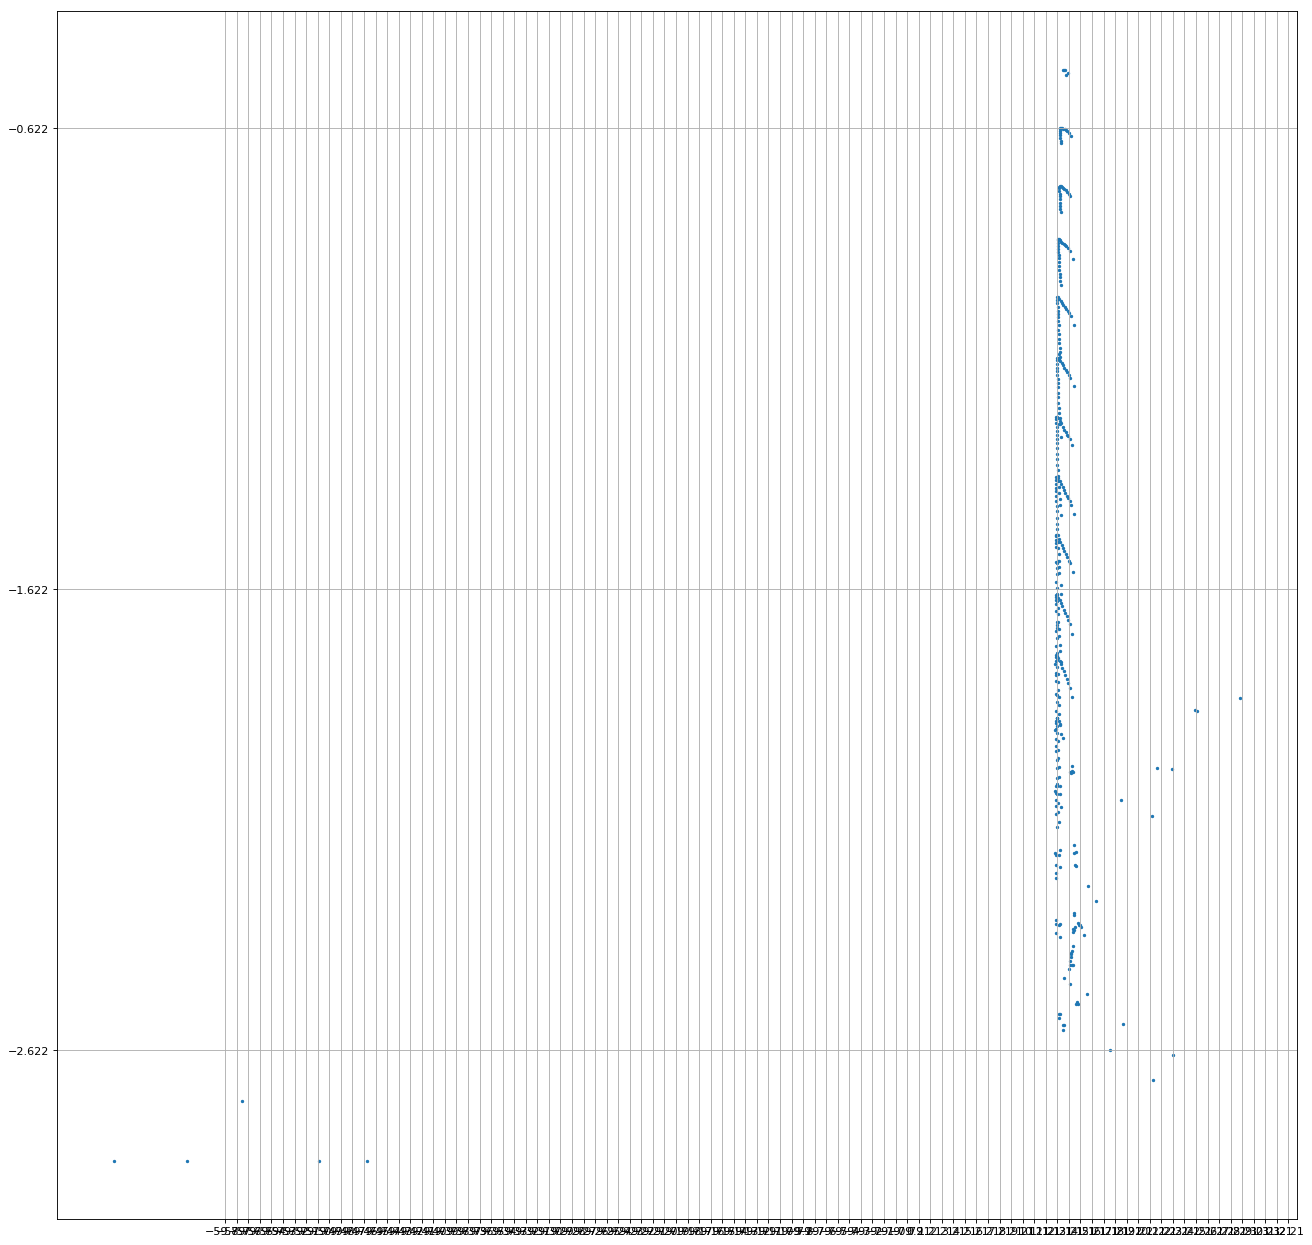

In [19]:
"""
Variables used in this cell are above, view, scene_to_view and tu
"""
# Variable for the gid size
grid_size = 1

# graph
plot_grid(scene_to_view, grid_size, view, x_range, y_range)